In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

/tmp/ipykernel_1350694/3675221686.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


### Load ATLAS exclusion curve

In [4]:
atlasCurve = np.genfromtxt('../../ATLAS_data/HEPData-ins2080541-v1-csv/MassLimitvs.Lifetime,Chargino,Observed.csv',
                        skip_header=9,
                        names=["Lifetime [ns]","Observed Limit [GeV]","1sigmaPlus","1sigmaMinus"],
                        delimiter=',')
atlasData = pd.read_pickle('../../ATLAS_data/charginoData.pcl')
atlasData.rename(columns={'mass (GeV)' : 'mLLP', 'lifetime (ns)' : 'tau_ns', 'width (GeV)' : 'width'},inplace=True)

### Load Recast Data

In [13]:
recastData = pd.read_pickle('./charginoRecast.pcl')
recastData = recastData.round({'tau_ns' : 2, 'mLLP' : 2})
# Remove stable points:
recastData = recastData[recastData['tau_ns'] < 1000.0]
print(len(recastData))
print(recastData.columns)

90
Index(['mLLP', 'mLSP', 'tau_ns', 'Luminosity (1/fb)', 'Regime', 'SR',
       'Target Mass [GeV]', '$N_s$', '$\sigma_{Ns}$', 'width',
       'Total MC Events', 'Total xsec (pb)', 'Mass Window',
       'Expected background', 'error +', 'error -', 'Observed', 'p0-value',
       'Local Z signif.', 'S95_exp', 'S95_obs', 'robs', 'rexp'],
      dtype='object')


### Get model points:

In [14]:
pts = list(set((zip(recastData['tau_ns'],recastData['mLLP']))))
robs = []
kfactors = []
# Select minimum mu_obs for each point
for tau,mLLP in pts:
    restData = recastData[(recastData['mLLP'] == mLLP) & (recastData['tau_ns'] == tau)]
    atlasDataR = atlasData[(atlasData['mLLP'] == mLLP) & (atlasData['tau_ns'] == tau)]
    robs.append(restData['robs'].min())
#     kfactors.append(atlasDataR['Signal Cross-Section (pb)'].iloc[0]/restData['Total xsec (pb)'].iloc[0])
robs = np.array(robs)
pts = np.array(pts)

In [15]:
kfactor = 1.25
robs = robs*kfactor

### Interpolate for a denser grid

In [16]:
newPts = np.array(list(product(np.linspace(np.log10(pts[:,0].min()), np.log10(pts[:,0].max()),100),
                                      np.linspace(pts[:,1].min(),pts[:,1].max(),100))))
muPts = griddata(list(zip(np.log10(pts[:,0]),pts[:,1])),robs,newPts)
newPts = newPts[~np.isnan(muPts)]
muPts = muPts[~np.isnan(muPts)]

In [17]:
newPts[:,0] = 10**newPts[:,0]

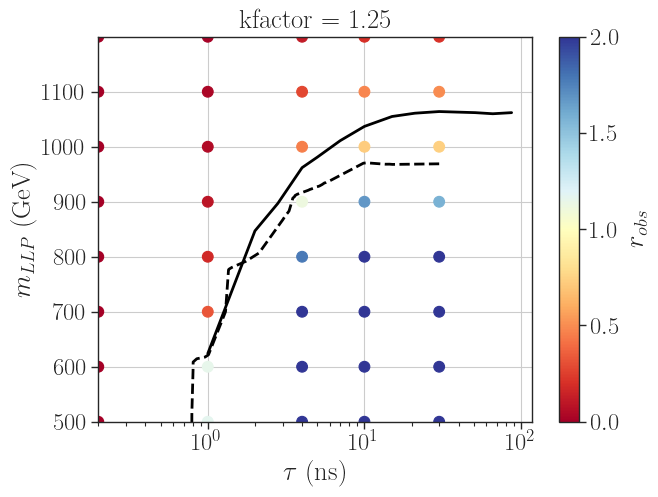

In [19]:
fig = plt.figure(figsize=(7,5))
plt.scatter(x=pts[:,0],y=pts[:,1],vmin=0.0,vmax=2.0,
            c=robs,cmap=cm,s=60)
cbar = plt.colorbar(label=r'$r_{obs}$')
plt.plot(atlasCurve["Lifetime_ns"],atlasCurve["Observed_Limit_GeV"],label='ATLAS',linewidth=2,color='black')

# plt.plot(smodelsCurve["tau_ns"],smodelsCurve["mLLP_GeV"],label='ATLAS-2016-32 (SModelS)',linewidth=2,color='gray')

plt.tricontour(newPts[:,0],newPts[:,1],muPts,levels=[1.0],
               linewidths=2,linestyles='dashed',colors='black')
plt.ylabel(r'$m_{LLP}$ (GeV)')
plt.xlabel(r'$\tau$ (ns)')
plt.ylim(500,1200)
# plt.xlim(0.5,100)
plt.yticks(np.arange(500.,1200.,100.))
plt.grid()
plt.xscale('log')
plt.title('kfactor = %1.2f' %kfactor)
# plt.text(0.1,0.7,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
#          transform = plt.gca().transAxes)
plt.show()